# Evaluating RAG pipelines

Large Language Models (LLMs) have taken the world by storm, showcasing impressive abilities in text generation and understanding. However, their reliance on static training data often limits their capacity to provide accurate and up-to-date responses, especially when dealing with specialized domains or rapidly evolving information. This is where Retrieval-Augmented Generation (RAG) steps in, offering a dynamic approach to enhance LLM performance. At its core, RAG involves retrieving relevant information from an external knowledge base and incorporating it into the LLM's input before generating a response. This allows the model to ground its output in factual, contextually appropriate data, effectively bridging the gap between static knowledge and real-time information.

The heart of RAG lies in its retrieval mechanism. Without the ability to accurately and efficiently retrieve the most pertinent context, the generation stage becomes futile, potentially leading to irrelevant or even misleading outputs. Therefore, the effectiveness of a RAG pipeline hinges on the accuracy of the retrieval component. Semantic search, where the query is passed through an embedding model and we search for similar chunks of information in embedding space, has achieved notable success. More advanced methods, such as hybrid search that combines keyword and semantic approaches, or graph-based retrieval, offer the potential for even better results (at the expense of greater computational cost). Each approach is suited to different use cases and data types.

Given the diverse range of retrieval strategies, it's vital to conduct a thorough experimentation to determine the optimal RAG pipeline for a specific application. This involves testing various chunking strategies and retrieval techniques. By systematically evaluating different configurations, we can identify the combination that yields the highest accuracy, relevance, and overall performance. 

In this post, I'll share the RAG experiments I've performed on the SEC 10-K filing benchmarking dataset we generated in previous posts, detailing the different pipelines I've explored and the insights I've gained along the way.


## Setup
First we need to import the required libraries and functions developed of this task.

In [1]:
#|include: false
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import HTML, Markdown, display
from matplotlib.colors import LinearSegmentedColormap

# Set up styling
plt.style.use('ggplot')
sns.set_palette("colorblind")

Most of the code developed for testing RAG pipelines has been added to the `src/rag` module in the project repository.

In [3]:
from src.rag.evaluation import evaluate_rag_configurations

We also need to define the location of the benchmark dataset created in the previous notebook and the directory where the processed reports are stored from notebook one.

In [4]:
BENCHMARK_DATASET_PATH = './data/benchmark/benchmark_dataset_reviewed.json' # Change to where you stored your reviewed benchmark dataset
PROCESSED_REPORTS_DIR = './data/processed/reports' # Processed reports from notebook one
OUTPUT_DIR = './pipelines'

# Retrieval Augmented Generation (RAG)
RAG is an approach that combines the strengths of information retrieval and natural language generation to provide accurate and contextually relevant answers to user queries. The process involves retrieving relevant documents from a large corpus and then generating an answer by conditioning on the retrieved documents.

The retrieval part of the RAG pipeline is crucial, as without accurate context the LLM cannot accurately answer the question (unless it happens to be trained on that question). The RAG pipeline offers various options to optimize the retrieval process, such as:

- **Chunking Methods**: Different methods such as token, semantic, and late chunking can be employed to split documents into manageable chunks for retrieval.
- **Chunk Sizes**: The size of chunks can be adjusted to balance between retrieval efficiency and contextual comprehensiveness.
- **Embedding Models**: Various embedding models like [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5) or [BAAI/bge-large-en-v1.5](https://huggingface.co/BAAI/bge-large-en-v1.5) can be used to convert text into vector representations for similarity comparison.
- **Reranking Options**: Post-retrieval reranking can be enabled to reorder the retrieved chunks based on relevance using models like [BAAI/bge-reranker-v2-m3](https://huggingface.co/BAAI/bge-reranker-v2-m3).
- **Hybrid Search Options**: Incorporating metadata filtering along with traditional retrieval can enhance precision by leveraging additional document metadata.


## Chunking Strategies for RAG Pipelines

One of the most critical components of an effective RAG pipeline is the chunking strategy - how we divide documents into smaller, manageable pieces for retrieval. The quality of chunking directly impacts both retrieval accuracy and the LLM's ability to generate relevant responses. In this evaluation, we use the [Chunkie](https://github.com/pszemraj/chunkie) library to implement and test different chunking approaches.

### The Chunkie Library

[Chunkie](https://github.com/pszemraj/chunkie) is a specialized Python library designed to handle document chunking for large language model applications. It provides a flexible framework for implementing various chunking strategies, with particular attention to maintaining semantic coherence and handling complex document structures.

For our RAG pipeline evaluation, we focused on three distinct chunking strategies provided by Chunkie: token-based, semantic, and late-binding chunking.

| Strategy | Description | Strengths | Weaknesses |
|----------|-------------|-----------|------------|
| Token-Based Chunking | Divides text into chunks based on a fixed token count | Simple, predictable, and computationally efficient | May split semantically related content across chunks |
| Semantic Chunking | Creates chunks based on semantic boundaries in the text | Preserves meaning and context within chunks | More computationally intensive than token-based |
| Late-Binding Chunking | Embeds the entire document first, then divides the embeddings into chunks | Maintains awareness of the entire document context in each chunk | Requires more memory to process entire documents at once |


## Embedding Models

Embedding models play a crucial role in transforming text data into vector representations, enabling efficient similarity searches in the embedding space. In our RAG pipeline evaluation, we experimented with different embedding models to determine which provides the best trade-off between accuracy and computational efficiency. Many embedding models are available, but we restrict the analysis to using the following open source model from HuggingFace:

* `bge-small-en-v1.5` which embeds to 384-dimensional space (available [here]([BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)))
* `bge-large-en-v1.5` which embeds to higher 1024-dimensional space (available [here](https://huggingface.co/BAAI/bge-large-en-v1.5))

By selecting a small and large model it enables us to see how the embedding dimension impacts the results. If you prefer to use the OpenAI API, you can use the `text-embedding-3-small` and `text-embedding-3-large` models to perform a similar test (note the OpenAI models are higher dimensional, with the small version outputting 1536 dimensional vectors), although you'll need to pay for it.

## Reranking

Reranking is often an essential step in refining the retrieval results by ordering the retrieved chunks based on their relevance. This process can significantly enhance the precision of the RAG pipeline, especially when combined with high-quality embedding models. An introduction to reranking can be found in [this](https://www.pinecone.io/learn/series/rag/rerankers/#Power-of-Rerankers) article.

In this study, we restricted the tests to using the [bge-reranker-v2-m3](https://huggingface.co/BAAI/bge-reranker-v2-m3) reranking model. 

## Hybrid Search

Hybrid search combines keyword-based and semantic search techniques to improve retrieval accuracy. By leveraging both lexical and semantic information, this approach can enhance the pipeline's ability to filter and retrieve relevant chunks effectively. Hybrid search is particularly beneficial when dealing with diverse data sources, allowing for more comprehensive and contextually relevant retrievals. In the case of the SEC 10-K filing reports, we can filter the retrieved data based on metadata such as company name and report year.


# Evaluation metrics

When evaluating RAG (Retrieval-Augmented Generation) pipelines, we need metrics that accurately reflect how well our system retrieves the information needed to answer user questions. The most important metric for RAG evaluation is one that measures whether we have retrieved all relevant information. Recall serves this purpose by measuring the proportion of reference spans that are adequately covered by retrieved chunks. While retrieving all relevant information is crucial, it's also important to know how quickly this information can be found. Mean Reciprocal Rank (MRR) measures this efficiency

## Contextual recall

### Issues using traditional recall
Traditional recall measures how many relevant references were retrieved out of all relevant references. The challenge here is defining when we consider a references to be accurately retrieved. A naive approach would fail due to:

* **Chunk Boundaries Don't Match Reference Spans**: Our system breaks documents into chunks that rarely align perfectly with the reference spans in our benchmark dataset. Using strict matching would result in a recall of 0 in most cases (even if it contained the useful information), which will not be helpful.
* **Formatting Differences**: Retrieved chunks may contain the same information but with different formatting, markdown elements, or surrounding context.
* **Partial Information**: A chunk might contain only part of the reference information, requiring multiple chunks to cover the complete reference.

Therefore we need a method to determine when a retrieved chunk contains the reference which is robust enough to deal with these issues.

### Why Not Use Vector Similarity?
One potential approach to determine whether a chunk contains information from a reference is measuring vector similarity. However, this method also has potential issues:

* **Threshold Challenges**: Financial documents contain many similar statements (e.g., "the company's net profit was $XX billion...") across different companies and time periods. Therefore it will be difficult to set a similarity threshold only identifies the true refernces.
* **False Positives**: Setting a similarity threshold low enough to catch true matches would likely include many semantically similar but factually distinct statements.

### Our Approach: Consecutive span coverage
For now, we'll use a relatively simple way to measure the recall based on the consecutive span coverage (I'm not sure if this is an actual term). This method searches for the longest consecutive matching substring between reference and retrieved text. If the length of this match exceeds a defined proportion of the original reference, we say that we have retrieved the correct reference. The final recall is the proportion of reference spans that are covered.

Before computing the consecutive span coverage, both the reference text and retrieved chunks are first normalized by removing markdown formatting, standardizing whitespace, and handling special characters. Without this we'll not find matches due to formatting differences between the two (e.g. when we asked the LLM to output reference spans for the benchmarking dataset in the second notebook, it would not include any formatting from the original text).

This approach provides a more realistic assessment of whether our RAG system retrieved the information needed to answer the question, even when chunks don't perfectly align with reference spans.

Below are a few examples showing how the consecutive span coverage is measured.


In [13]:
#| echo: false

# Examples with nice formatting

display(Markdown("""
## Examples of Contextual Span Coverage

Let's look at some concrete examples to understand how this metric works in practice:
"""))

# Example 1
display(HTML("""
<div style="background-color:#f8f9fa; padding:15px; border-radius:5px; margin-bottom:20px;">
    <h3 style="color:#28a745;">Example 1: Perfect Coverage (Score = 1.0)</h3>
    
    <div style="margin-bottom:15px;">
        <h4>Reference Span:</h4>
        <div style="background-color:#e9ecef; padding:10px; border-radius:5px; font-family:monospace;">
            Apple's total net sales increased 33% or $91.3 billion during 2021 compared to 2020, driven by growth in all Products and Services categories.
        </div>
    </div>
    
    <div style="margin-bottom:15px;">
        <h4>Retrieved Chunk:</h4>
        <div style="background-color:#e9ecef; padding:10px; border-radius:5px; font-family:monospace;">
            Financial Results<br>
            Our financial results for fiscal 2021 demonstrate the success of our innovation and execution despite continued uncertainty in the macro environment.<br><br>
            <span style="background-color:#ffc10780;">Apple's total net sales increased 33% or $91.3 billion during 2021 compared to 2020, driven by growth in all Products and Services categories.</span> Our products net sales increased $77.3 billion or 35% during 2021 compared to 2020.
        </div>
    </div>
    
    <div>
        <h4>Explanation:</h4>
        <p>Even though the retrieved chunk contains additional text before and after the reference span, the entire reference is contained within the chunk (highlighted in yellow), resulting in a perfect coverage score of 1.0. In this case the referenece would be classified as successfully retrieved for the purpose of recall calculation.</p>
    </div>
</div>
"""))

# Example 2
display(HTML("""
<div style="background-color:#f8f9fa; padding:15px; border-radius:5px; margin-bottom:20px;">
    <h3 style="color:#f0ad4e;">Example 2: Low Coverage (Score = 0.15)</h3>
    
    <div style="margin-bottom:15px;">
        <h4>Reference Span:</h4>
        <div style="background-color:#e9ecef; padding:10px; border-radius:5px; font-family:monospace;">
            NVIDIA's revenue grew 7% in fiscal year 2016 to a record $5.01 billion, reflecting growth in GeForce GPUs for gaming and Tesla products for datacenter.
        </div>
    </div>
    
    <div style="margin-bottom:15px;">
        <h4>Retrieved Chunk:</h4>
        <div style="background-color:#e9ecef; padding:10px; border-radius:5px; font-family:monospace;">
            For fiscal 2017, revenue was $6.91 billion, up 38% from <span style="background-color:#ffe0b2;">$5.01 billion</span> a year earlier. GPU business revenue was $5.82 billion, up 39% from a year earlier, with growth across all platforms.
        </div>
    </div>
    
    <div>
        <h4>Explanation:</h4>
        <p>The retrieved chunk contains a small portion of the reference span (the "$5.01 billion" amount), which represents the longest consecutive match. However, this covers only about 15% of the reference text and lacks the critical context about fiscal year 2016, NVIDIA's 7% growth, and the specific products contributing to that growth. With a coverage score of 0.15, this falls well below our typical threshold of 0.5 and would not be considered a successful retrieval.</p>
    </div>
</div>
"""))

# Example 3
display(HTML("""
<div style="background-color:#f8f9fa; padding:15px; border-radius:5px; margin-bottom:20px;">
    <h3 style="color:#fd7e14;">Example 3: Partial Coverage (Score = 0.75)</h3>
    
    <div style="margin-bottom:15px;">
        <h4>Reference Span:</h4>
        <div style="background-color:#e9ecef; padding:10px; border-radius:5px; font-family:monospace;">
            <span style="background-color:#ffc10780;">NVIDIA reported record data center revenue of $3.81 billion in Q4, up 11% from Q3 and up 165% from a year ago.</span> This growth reflects increased demand for AI solutions.
        </div>
    </div>
    
    <div style="margin-bottom:15px;">
        <h4>Retrieved Chunk:</h4>
        <div style="background-color:#e9ecef; padding:10px; border-radius:5px; font-family:monospace;">
            Financial Performance Highlights:<br><br>
            Gaming revenue for the fourth quarter was $1.83 billion, down 7% sequentially and up 37% from a year ago.<br><br>
            <span style="background-color:#ffc10780;">NVIDIA reported record data center revenue of $3.81 billion in Q4, up 11% from Q3 and up 165% from a year ago.</span>
        </div>
    </div>
    
    <div>
        <h4>Explanation:</h4>
        <p>The retrieved chunk contains the complete first sentence of the reference (highlighted in yellow), which contains the most significant information about NVIDIA's data center revenue. However, it's missing the second sentence "This growth reflects increased demand for AI solutions." Since the first sentence contains approximately 75% of the total reference content and includes the key financial data, this would exceed our typical threshold of 0.5 and be considered a successful retrieval.</p>
    </div>
</div>
"""))


## Examples of Contextual Span Coverage

Let's look at some concrete examples to understand how this metric works in practice:


It's obviously not a perfect method, but it seems to do a decent job for now that enables us to evaluate different RAG pipelines.

## Mean Reciprocal Rank (MRR) in RAG Evaluation
In addition to recall, another important metric for evaluating RAG systems is Mean Reciprocal Rank (MRR). While Contextual Span Coverage measures how well the retrieved chunks cover the reference information, MRR focuses on how quickly the system finds relevant information.

### What is Mean Reciprocal Rank?
Mean Reciprocal Rank (MRR) is a statistic that measures the effectiveness of a retrieval system based on the position of the first relevant item in the result list. The reciprocal rank for a query is the inverse of the rank of the first relevant document:

$$RR = \frac{1}{rank}$$

If the first relevant document is at position 1, the reciprocal rank is 1. If it's at position 2, the reciprocal rank is 1/2, and so on. The mean reciprocal rank is the average of the reciprocal ranks across all queries:

$$MRR = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{rank_i}$$

where |Q| is the number of queries and rank_i is the rank of the first relevant document for the i-th query.

### MRR Calculation Example
Below is an example of how mean reciprocal rank is computed.


In [3]:
#| echo: false

# Create a visual example of MRR calculation
display(HTML("""
<div style="background-color:#f8f9fa; padding:15px; border-radius:5px; margin-bottom:20px;">
    <h3>MRR Calculation Example</h3>
    
    <table style="width:100%; border-collapse: collapse; margin-bottom:15px;">
        <thead>
            <tr style="background-color:#e9ecef;">
                <th style="padding:8px; border:1px solid #dee2e6;">Query</th>
                <th style="padding:8px; border:1px solid #dee2e6;">Position of First Relevant Document</th>
                <th style="padding:8px; border:1px solid #dee2e6;">Reciprocal Rank</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="padding:8px; border:1px solid #dee2e6;">What was Apple's revenue in 2021?</td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">1</td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">1/1 = 1.0</td>
            </tr>
            <tr>
                <td style="padding:8px; border:1px solid #dee2e6;">How many stockholders did Google have in 2020?</td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">3</td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">1/3 ≈ 0.33</td>
            </tr>
            <tr>
                <td style="padding:8px; border:1px solid #dee2e6;">What were NVIDIA's main revenue drivers in 2019?</td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">2</td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">1/2 = 0.5</td>
            </tr>
            <tr>
                <td style="padding:8px; border:1px solid #dee2e6;">What was Microsoft's R&D spending in 2018?</td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">4</td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">1/4 = 0.25</td>
            </tr>
            <tr style="background-color:#e9ecef; font-weight:bold;">
                <td style="padding:8px; border:1px solid #dee2e6;">Mean Reciprocal Rank (MRR)</td>
                <td style="padding:8px; border:1px solid #dee2e6;"></td>
                <td style="padding:8px; border:1px solid #dee2e6; text-align:center;">(1.0 + 0.33 + 0.5 + 0.25)/4 = 0.52</td>
            </tr>
        </tbody>
    </table>
    
    <p>In this example, the MRR is 0.52, indicating that on average, the first relevant document appears around position 2 in the result list.</p>
</div>
"""))

Query,Position of First Relevant Document,Reciprocal Rank
What was Apple's revenue in 2021?,1,1/1 = 1.0
How many stockholders did Google have in 2020?,3,1/3 ≈ 0.33
What were NVIDIA's main revenue drivers in 2019?,2,1/2 = 0.5
What was Microsoft's R&D spending in 2018?,4,1/4 = 0.25
Mean Reciprocal Rank (MRR),,(1.0 + 0.33 + 0.5 + 0.25)/4 = 0.52


## Comparison between recall and MRR
The table below summarizes the complementary features of the two metrics.

In [14]:
#| echo: false

# Create comparison table
comparison_data = {
    'Aspect': ['Focus', 'What it measures', "When it's most useful", 'Limitations'],
    'MRR': [
        'Position of first relevant result',
        'How quickly the system finds relevant information',
        'When ranking quality is important',
        "Doesn't consider multiple relevant documents or partial relevance"
    ],
    'Contextual Span Recall': [
        'Content coverage across all retrieved chunks',
        'How much of the reference information is retrieved',
        'When comprehensive information gathering is important',
        "Doesn't consider the position of relevant information and is dependent on the selection of the span threshold"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
display(HTML(df_comparison.to_html(index=False, classes='table table-striped table-hover')))

Aspect,MRR,Contextual Span Recall
Focus,Position of first relevant result,Content coverage across all retrieved chunks
What it measures,How quickly the system finds relevant information,How much of the reference information is retrieved
When it's most useful,When ranking quality is important,When comprehensive information gathering is important
Limitations,Doesn't consider multiple relevant documents or partial relevance,Doesn't consider the position of relevant information and is dependent on the selection of the span threshold


By using both metrics together, we may be able to get a more complete picture of our RAG system's performance:

* **High MRR, Low recall**: The system quickly finds some relevant information but misses important details.
* **Low MRR, High recall**: The system eventually retrieves most of the needed information but buries it too deep in the results.
* **High MRR, High recall**: The ideal scenario where relevant information is both comprehensive and prominently positioned.

On reflection, the recall metric is the more useful here. The MRR (at least in it's present form) doesn't consider all references (only the position of the first match), but what is vital for the LLM to answer the question correctly is that we provide all relevant references (which is captured by a recall of 1.0). We'll output the MRR as a useful supplementary statistic, but the focus will be on the recall measurement.


# Retrieval pipelie evaluation

In this section, we run various RAG pipeline configurations and evaluate the performance on the benchmarking dataset (see second notebook). 

## Retrieval pipeline options

The options included are:

**Chunking Strategies**

* Token-based chunking: Divides text into chunks based on a fixed token count
* Semantic chunking: Creates chunks based on semantic boundaries in the text
* Late-binding chunking: Embeds the entire document first, then divides the embeddings into chunks

**Chunk Sizes**

* Either 200 or 400 tokens (for semantic and late-binding this will be the maximum chunk size)

**Embedding Models**

* Small embedding model: `BAAI/bge-small-en-v1.5`
* Large embedding model: `BAAI/bge-large-en-v1.5` 

**Reranking Options**

* No reranking: Standard retrieval without reranking
* With reranking: Using the `BAAI/bge-reranker-v2-m3` model to rerank retrieved chunks


**Hybrid Search Options**

* Standard search: Basic semantic search using embeddings only
* Hybrid search: Combining semantic search with metadata filtering. For now, 

### Base configuration
Each base configuration is defined by a specific chunking strategy (token, semantic or late-binding), embedding model, and (maximum) chunk size. These base configurations are further evaluated across four different retrieval strategies:

1. **Standard**: Basic semantic search retrieval without enhancements.
2. **With Reranking**: Retrieving chunks are reordered based on relevance using a reranking model.
3. **With Metadata Filtering**: Retrieval is enhanced by filtering based on document metadata.
4. **With Both**: Combines both reranking and metadata filtering for optimal retrieval performance.

## Implementation details

The RAG retrieval pipeline is implemented using a modular architecture with Chunkie for document chunking and LanceDB for vector storage and retrieval. Here's a brief overview of how the pipeline works:

### Document Processing and Chunking with Chunkie

1. **Document Ingestion:**
* SEC filings have already been processed to extract cleaned text (in markdown format) and tables in cleaned HTML format (after having most of formatting removed). Processed reports were generated in the first notebook.
* HTML tables are optionally removed based on configuration. In this analysis we'll remove the tabular data for now as this will require further work to properly embed the content.

2. **Chunking Strategies (via Chunkie library):**

One of the following chunking methods is used to chunk the processed reports into smaller components:
* Token-based chunking: Splits documents into fixed-size chunks based on token count
* Semantic chunking: Creates chunks based on semantic boundaries in the text
* Late-binding chunking: Embeds the entire document first, then divides into chunks

3. **Metadata Extraction:**

Each chunk is enriched with metadata including:
* Company ticker symbol (e.g. APPL, NVDA ...). We use the ticker as it's more consistent than the company name.
* Filing year
* Section information

### Vector Storage with LanceDB

[LanceDB](https://lancedb.github.io/lancedb/) is used as the vector store, which can store embeddings along with chunk text and metadata. It provides efficient vector similarity search capabilitie and supports hybrid search using metadata filtering.

1. **Embedding Generation:**

Text chunks are embedded using one of the selected embedding models:
* BAAI/bge-small-en-v1.5 (384 dimensions)
* BAAI/bge-large-en-v1.5 (1024 dimensions)
* OpenAI embedding models (not tested here)

2. **Vector Database:**

The resulting embeddings are stored in a LanceDB database instance, along with the corresponding text and metadata.

### Retrieval Process

1. **Query Processing:**

When we pass a user query (such as the example question sin the benchmarking dataset), we follow this process:

* The user query is embedded using the same embedding model as used for the documents
* Metadata filters are extracted from the query using regex patterns. Currently company names are extracted using rule-based methods and then mapped to ticker symbols. Years are also extracted. When a year is extracted, we also include the next year in the filtering. This is because often the results for one year are included in the next years report. 

2. **Search Options:**

Once we have a vector database established, we can test four retrieval methods using the same database:
* Standard search: Pure vector similarity search
* Hybrid search: Combines vector similarity with metadata filtering
* Reranking: Optional reranking of retrieved chunks using BAAI/bge-reranker-v2-m3
* Hybrid plus reranking: Apply both hybrid search and reranking

3. **Result Handling:**

The top-k chunks are retrieved based on similarity scores. When reranking is enabled, chunks are re-scored based on their relevance to the query. Results include both the chunk text and associated metadata

## Run evaluation

The goal is to identify which combination of chunking strategy, embedding model, and chunk size, along with the retrieval strategy, provides the best performance in terms of recall and MRR metrics.

Now we run the evaluation using the `evaluate_rag_configurations` function from the `src/rag` module in the repository:

In [5]:
#| output: false

# Run focused evaluation with your specific parameters
results = evaluate_rag_configurations(
    benchmark_path=BENCHMARK_DATASET_PATH,
    reports_dir=PROCESSED_REPORTS_DIR,
    output_base_dir=OUTPUT_DIR,
    # Only use the specific parameters you want to test
    chunking_methods=["token","semantic","late"],
    chunk_sizes=[200,400],  
    embedding_models=["BAAI/bge-small-en-v1.5", "BAAI/bge-large-en-v1.5"],  
    reranking_options=[False,True],  # Both with and without reranking
    hybrid_search_options=[False,True],  # Both with and without metadata filtering
    remove_tables_options=[True],  # For now we'll remove tables as they need additional processing
    reranker_model="BAAI/bge-reranker-v2-m3",
    reranker_top_k=100, # Number of retrieved chunks to run reranking on
    k_values=[1, 3, 5, 10, 20, 30, 50, 100],
    coverage_threshold=0.5, # Used for computing consecutive recall
    max_questions=None,
    skip_existing=True,
    restart_from_existing=True,
    verbose=True
)

Created new run directory: ./pipelines/run_20250314_220111
Evaluating 48 RAG pipeline configurations:
Base configurations: 12
Total configurations: 48

Base configurations:
- token_chunk200_bge-small-en-v1.5_no_tables
- token_chunk200_bge-large-en-v1.5_no_tables
- token_chunk400_bge-small-en-v1.5_no_tables
- token_chunk400_bge-large-en-v1.5_no_tables
- semantic_chunk200_bge-small-en-v1.5_no_tables
- semantic_chunk200_bge-large-en-v1.5_no_tables
- semantic_chunk400_bge-small-en-v1.5_no_tables
- semantic_chunk400_bge-large-en-v1.5_no_tables
- late_chunk200_bge-small-en-v1.5_no_tables
- late_chunk200_bge-large-en-v1.5_no_tables
- late_chunk400_bge-small-en-v1.5_no_tables
- late_chunk400_bge-large-en-v1.5_no_tables

All configurations:
1. token_chunk200_bge-small-en-v1.5_no_tables_standard
2. token_chunk200_bge-large-en-v1.5_no_tables_standard
3. token_chunk400_bge-small-en-v1.5_no_tables_standard
4. token_chunk400_bge-large-en-v1.5_no_tables_standard
5. semantic_chunk200_bge-small-en-v1.5

Evaluating configurations:   0%|          | 0/48 [00:00<?, ?it/s]


Evaluating configuration: token_chunk200_bge-small-en-v1.5_no_tables_standard (1/48)
Base configuration: token_chunk200_bge-small-en-v1.5_no_tables
Chunking method: token
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Disabled
Creating new vector store for token_chunk200_bge-small-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Processing companies: 100%|██████████| 5/5 [00:00<00:00, 10.37it/s]


Created 7956 chunks
Generating embeddings...
Embedding batch 40/40
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]


Saved plot to ./pipelines/run_20250314_220111/token_chunk200_bge-small-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:   2%|▏         | 1/48 [01:01<48:25, 61.82s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk200_bge-small-en-v1.5_no_tables_standard evaluated in 61.82 seconds

Evaluating configuration: token_chunk200_bge-large-en-v1.5_no_tables_standard (2/48)
Base configuration: token_chunk200_bge-large-en-v1.5_no_tables
Chunking method: token
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Disabled
Creating new vector store for token_chunk200_bge-large-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Processing companies: 100%|██████████| 5/5 [00:00<00:00, 10.74it/s]


Created 7956 chunks
Generating embeddings...
Embedding batch 40/40
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]


Saved plot to ./pipelines/run_20250314_220111/token_chunk200_bge-large-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:   4%|▍         | 2/48 [06:00<2:34:15, 201.22s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk200_bge-large-en-v1.5_no_tables_standard evaluated in 298.79 seconds

Evaluating configuration: token_chunk400_bge-small-en-v1.5_no_tables_standard (3/48)
Base configuration: token_chunk400_bge-small-en-v1.5_no_tables
Chunking method: token
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Disabled
Creating new vector store for token_chunk400_bge-small-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Processing companies: 100%|██████████| 5/5 [00:00<00:00, 13.64it/s]


Created 3514 chunks
Generating embeddings...
Embedding batch 18/18
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


Saved plot to ./pipelines/run_20250314_220111/token_chunk400_bge-small-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:   6%|▋         | 3/48 [06:41<1:35:52, 127.84s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk400_bge-small-en-v1.5_no_tables_standard evaluated in 40.53 seconds

Evaluating configuration: token_chunk400_bge-large-en-v1.5_no_tables_standard (4/48)
Base configuration: token_chunk400_bge-large-en-v1.5_no_tables
Chunking method: token
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Disabled
Creating new vector store for token_chunk400_bge-large-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Processing companies: 100%|██████████| 5/5 [00:00<00:00, 11.52it/s]


Created 3514 chunks
Generating embeddings...
Embedding batch 18/18
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


Saved plot to ./pipelines/run_20250314_220111/token_chunk400_bge-large-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:   8%|▊         | 4/48 [10:08<1:56:53, 159.39s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk400_bge-large-en-v1.5_no_tables_standard evaluated in 207.76 seconds

Evaluating configuration: semantic_chunk200_bge-small-en-v1.5_no_tables_standard (5/48)
Base configuration: semantic_chunk200_bge-small-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Creating new vector store for semantic_chunk200_bge-small-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Processing companies: 100%|██████████| 5/5 [01:22<00:00, 16.46s/it]


Created 17605 chunks
Generating embeddings...
Embedding batch 89/89
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  6.73it/s]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk200_bge-small-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  10%|█         | 5/48 [12:15<1:45:46, 147.60s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk200_bge-small-en-v1.5_no_tables_standard evaluated in 126.68 seconds

Evaluating configuration: semantic_chunk200_bge-large-en-v1.5_no_tables_standard (6/48)
Base configuration: semantic_chunk200_bge-large-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Creating new vector store for semantic_chunk200_bge-large-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Processing companies: 100%|██████████| 5/5 [01:16<00:00, 15.20s/it]


Created 17605 chunks
Generating embeddings...
Embedding batch 89/89
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk200_bge-large-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  12%|█▎        | 6/48 [17:25<2:21:54, 202.72s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk200_bge-large-en-v1.5_no_tables_standard evaluated in 309.71 seconds

Evaluating configuration: semantic_chunk400_bge-small-en-v1.5_no_tables_standard (7/48)
Base configuration: semantic_chunk400_bge-small-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Creating new vector store for semantic_chunk400_bge-small-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Processing companies: 100%|██████████| 5/5 [01:15<00:00, 15.00s/it]


Created 14700 chunks
Generating embeddings...
Embedding batch 74/74
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  4.73it/s]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk400_bge-small-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  15%|█▍        | 7/48 [19:29<2:00:55, 176.96s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk400_bge-small-en-v1.5_no_tables_standard evaluated in 123.92 seconds

Evaluating configuration: semantic_chunk400_bge-large-en-v1.5_no_tables_standard (8/48)
Base configuration: semantic_chunk400_bge-large-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Creating new vector store for semantic_chunk400_bge-large-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Processing companies: 100%|██████████| 5/5 [01:14<00:00, 14.81s/it]


Created 14700 chunks
Generating embeddings...
Embedding batch 74/74
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk400_bge-large-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  17%|█▋        | 8/48 [24:56<2:29:49, 224.75s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk400_bge-large-en-v1.5_no_tables_standard evaluated in 327.07 seconds

Evaluating configuration: late_chunk200_bge-small-en-v1.5_no_tables_standard (9/48)
Base configuration: late_chunk200_bge-small-en-v1.5_no_tables
Chunking method: late
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Creating new vector store for late_chunk200_bge-small-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Token indices sequence length is longer than the specified maximum sequence length for this model (7158 > 512). Running this sequence through the model will result in indexing errors
Processing companies: 100%|██████████| 5/5 [00:35<00:00,  7.09s/it]


Created 9064 chunks
Generating embeddings...
Embedding batch 46/46
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  6.85it/s]


Saved plot to ./pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  19%|█▉        | 9/48 [26:11<1:55:43, 178.03s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk200_bge-small-en-v1.5_no_tables_standard evaluated in 75.30 seconds

Evaluating configuration: late_chunk200_bge-large-en-v1.5_no_tables_standard (10/48)
Base configuration: late_chunk200_bge-large-en-v1.5_no_tables
Chunking method: late
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Creating new vector store for late_chunk200_bge-large-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Token indices sequence length is longer than the specified maximum sequence length for this model (7158 > 512). Running this sequence through the model will result in indexing errors
Processing companies: 100%|██████████| 5/5 [00:35<00:00,  7.09s/it]


Created 9064 chunks
Generating embeddings...
Embedding batch 46/46
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


Saved plot to ./pipelines/run_20250314_220111/late_chunk200_bge-large-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  21%|██        | 10/48 [30:10<2:04:43, 196.94s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk200_bge-large-en-v1.5_no_tables_standard evaluated in 239.30 seconds

Evaluating configuration: late_chunk400_bge-small-en-v1.5_no_tables_standard (11/48)
Base configuration: late_chunk400_bge-small-en-v1.5_no_tables
Chunking method: late
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Creating new vector store for late_chunk400_bge-small-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Token indices sequence length is longer than the specified maximum sequence length for this model (7158 > 512). Running this sequence through the model will result in indexing errors
Processing companies: 100%|██████████| 5/5 [00:36<00:00,  7.20s/it]


Created 4358 chunks
Generating embeddings...
Embedding batch 22/22
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]


Saved plot to ./pipelines/run_20250314_220111/late_chunk400_bge-small-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  23%|██▎       | 11/48 [31:21<1:37:36, 158.27s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk400_bge-small-en-v1.5_no_tables_standard evaluated in 70.58 seconds

Evaluating configuration: late_chunk400_bge-large-en-v1.5_no_tables_standard (12/48)
Base configuration: late_chunk400_bge-large-en-v1.5_no_tables
Chunking method: late
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Creating new vector store for late_chunk400_bge-large-en-v1.5_no_tables
Processing documents...
Loading documents...
Loaded 5 documents
Chunking documents...


Token indices sequence length is longer than the specified maximum sequence length for this model (7158 > 512). Running this sequence through the model will result in indexing errors
Processing companies: 100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


Created 4358 chunks
Generating embeddings...
Embedding batch 22/22
Creating vector store...
Vector store created successfully
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


Saved plot to ./pipelines/run_20250314_220111/late_chunk400_bge-large-en-v1.5_no_tables/standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  25%|██▌       | 12/48 [35:16<1:49:03, 181.77s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk400_bge-large-en-v1.5_no_tables_standard evaluated in 235.51 seconds

Evaluating configuration: token_chunk200_bge-small-en-v1.5_no_tables_no_reranking_hybrid (13/48)
Base configuration: token_chunk200_bge-small-en-v1.5_no_tables
Chunking method: token
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Enabled
Reusing existing vector store for token_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


Saved plot to ./pipelines/run_20250314_220111/token_chunk200_bge-small-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  27%|██▋       | 13/48 [35:25<1:15:22, 129.20s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk200_bge-small-en-v1.5_no_tables_no_reranking_hybrid evaluated in 8.24 seconds

Evaluating configuration: token_chunk200_bge-small-en-v1.5_no_tables_with_reranking_standard (14/48)
Base configuration: token_chunk200_bge-small-en-v1.5_no_tables
Chunking method: token
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled
Reusing existing vector store for token_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:37<00:00,  4.18s/it]


Saved plot to ./pipelines/run_20250314_220111/token_chunk200_bge-small-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  29%|██▉       | 14/48 [36:23<1:01:01, 107.68s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk200_bge-small-en-v1.5_no_tables_with_reranking_standard evaluated in 57.94 seconds

Evaluating configuration: token_chunk200_bge-small-en-v1.5_no_tables_with_reranking_hybrid (15/48)
Base configuration: token_chunk200_bge-small-en-v1.5_no_tables
Chunking method: token
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled
Reusing existing vector store for token_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:33<00:00,  3.74s/it]


Saved plot to ./pipelines/run_20250314_220111/token_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  31%|███▏      | 15/48 [37:07<48:47, 88.71s/it]   

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk200_bge-small-en-v1.5_no_tables_with_reranking_hybrid evaluated in 44.75 seconds

Evaluating configuration: token_chunk200_bge-large-en-v1.5_no_tables_no_reranking_hybrid (16/48)
Base configuration: token_chunk200_bge-large-en-v1.5_no_tables
Chunking method: token
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Enabled
Reusing existing vector store for token_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


Saved plot to ./pipelines/run_20250314_220111/token_chunk200_bge-large-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  33%|███▎      | 16/48 [37:15<34:14, 64.22s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk200_bge-large-en-v1.5_no_tables_no_reranking_hybrid evaluated in 7.33 seconds

Evaluating configuration: token_chunk200_bge-large-en-v1.5_no_tables_with_reranking_standard (17/48)
Base configuration: token_chunk200_bge-large-en-v1.5_no_tables
Chunking method: token
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled
Reusing existing vector store for token_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:40<00:00,  4.49s/it]


Saved plot to ./pipelines/run_20250314_220111/token_chunk200_bge-large-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  35%|███▌      | 17/48 [38:05<30:56, 59.87s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk200_bge-large-en-v1.5_no_tables_with_reranking_standard evaluated in 49.77 seconds

Evaluating configuration: token_chunk200_bge-large-en-v1.5_no_tables_with_reranking_hybrid (18/48)
Base configuration: token_chunk200_bge-large-en-v1.5_no_tables
Chunking method: token
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled
Reusing existing vector store for token_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:34<00:00,  3.82s/it]


Saved plot to ./pipelines/run_20250314_220111/token_chunk200_bge-large-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  38%|███▊      | 18/48 [38:49<27:37, 55.27s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk200_bge-large-en-v1.5_no_tables_with_reranking_hybrid evaluated in 44.54 seconds

Evaluating configuration: token_chunk400_bge-small-en-v1.5_no_tables_no_reranking_hybrid (19/48)
Base configuration: token_chunk400_bge-small-en-v1.5_no_tables
Chunking method: token
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Enabled
Reusing existing vector store for token_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]


Saved plot to ./pipelines/run_20250314_220111/token_chunk400_bge-small-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  40%|███▉      | 19/48 [38:59<20:04, 41.54s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk400_bge-small-en-v1.5_no_tables_no_reranking_hybrid evaluated in 9.56 seconds

Evaluating configuration: token_chunk400_bge-small-en-v1.5_no_tables_with_reranking_standard (20/48)
Base configuration: token_chunk400_bge-small-en-v1.5_no_tables
Chunking method: token
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled
Reusing existing vector store for token_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [01:14<00:00,  8.31s/it]


Saved plot to ./pipelines/run_20250314_220111/token_chunk400_bge-small-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  42%|████▏     | 20/48 [40:23<25:22, 54.38s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk400_bge-small-en-v1.5_no_tables_with_reranking_standard evaluated in 84.29 seconds

Evaluating configuration: token_chunk400_bge-small-en-v1.5_no_tables_with_reranking_hybrid (21/48)
Base configuration: token_chunk400_bge-small-en-v1.5_no_tables
Chunking method: token
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled
Reusing existing vector store for token_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [01:08<00:00,  7.62s/it]


Saved plot to ./pipelines/run_20250314_220111/token_chunk400_bge-small-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  44%|████▍     | 21/48 [41:42<27:46, 61.71s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk400_bge-small-en-v1.5_no_tables_with_reranking_hybrid evaluated in 78.82 seconds

Evaluating configuration: token_chunk400_bge-large-en-v1.5_no_tables_no_reranking_hybrid (22/48)
Base configuration: token_chunk400_bge-large-en-v1.5_no_tables
Chunking method: token
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Enabled
Reusing existing vector store for token_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]


Saved plot to ./pipelines/run_20250314_220111/token_chunk400_bge-large-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  46%|████▌     | 22/48 [41:52<20:05, 46.38s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk400_bge-large-en-v1.5_no_tables_no_reranking_hybrid evaluated in 10.62 seconds

Evaluating configuration: token_chunk400_bge-large-en-v1.5_no_tables_with_reranking_standard (23/48)
Base configuration: token_chunk400_bge-large-en-v1.5_no_tables
Chunking method: token
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled
Reusing existing vector store for token_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [08:35<00:00, 57.32s/it]


Saved plot to ./pipelines/run_20250314_220111/token_chunk400_bge-large-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  48%|████▊     | 23/48 [50:38<1:19:17, 190.32s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk400_bge-large-en-v1.5_no_tables_with_reranking_standard evaluated in 526.04 seconds

Evaluating configuration: token_chunk400_bge-large-en-v1.5_no_tables_with_reranking_hybrid (24/48)
Base configuration: token_chunk400_bge-large-en-v1.5_no_tables
Chunking method: token
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled
Reusing existing vector store for token_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [01:07<00:00,  7.50s/it]


Saved plot to ./pipelines/run_20250314_220111/token_chunk400_bge-large-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  50%|█████     | 24/48 [52:02<1:03:22, 158.42s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration token_chunk400_bge-large-en-v1.5_no_tables_with_reranking_hybrid evaluated in 84.01 seconds

Evaluating configuration: semantic_chunk200_bge-small-en-v1.5_no_tables_no_reranking_hybrid (25/48)
Base configuration: semantic_chunk200_bge-small-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  5.34it/s]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk200_bge-small-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  52%|█████▏    | 25/48 [52:13<43:46, 114.18s/it]  

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk200_bge-small-en-v1.5_no_tables_no_reranking_hybrid evaluated in 10.99 seconds

Evaluating configuration: semantic_chunk200_bge-small-en-v1.5_no_tables_with_reranking_standard (26/48)
Base configuration: semantic_chunk200_bge-small-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:22<00:00,  2.47s/it]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk200_bge-small-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  54%|█████▍    | 26/48 [52:49<33:12, 90.56s/it] 

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk200_bge-small-en-v1.5_no_tables_with_reranking_standard evaluated in 35.44 seconds

Evaluating configuration: semantic_chunk200_bge-small-en-v1.5_no_tables_with_reranking_hybrid (27/48)
Base configuration: semantic_chunk200_bge-small-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:23<00:00,  2.60s/it]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  56%|█████▋    | 27/48 [53:28<26:17, 75.13s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk200_bge-small-en-v1.5_no_tables_with_reranking_hybrid evaluated in 39.14 seconds

Evaluating configuration: semantic_chunk200_bge-large-en-v1.5_no_tables_no_reranking_hybrid (28/48)
Base configuration: semantic_chunk200_bge-large-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  7.48it/s]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk200_bge-large-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  58%|█████▊    | 28/48 [53:40<18:46, 56.34s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk200_bge-large-en-v1.5_no_tables_no_reranking_hybrid evaluated in 12.48 seconds

Evaluating configuration: semantic_chunk200_bge-large-en-v1.5_no_tables_with_reranking_standard (29/48)
Base configuration: semantic_chunk200_bge-large-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:22<00:00,  2.48s/it]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk200_bge-large-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  60%|██████    | 29/48 [54:16<15:52, 50.12s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk200_bge-large-en-v1.5_no_tables_with_reranking_standard evaluated in 35.60 seconds

Evaluating configuration: semantic_chunk200_bge-large-en-v1.5_no_tables_with_reranking_hybrid (30/48)
Base configuration: semantic_chunk200_bge-large-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:22<00:00,  2.51s/it]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk200_bge-large-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  62%|██████▎   | 30/48 [54:55<13:59, 46.66s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk200_bge-large-en-v1.5_no_tables_with_reranking_hybrid evaluated in 38.59 seconds

Evaluating configuration: semantic_chunk400_bge-small-en-v1.5_no_tables_no_reranking_hybrid (31/48)
Base configuration: semantic_chunk400_bge-small-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  6.80it/s]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk400_bge-small-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  65%|██████▍   | 31/48 [55:10<10:35, 37.36s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk400_bge-small-en-v1.5_no_tables_no_reranking_hybrid evaluated in 15.68 seconds

Evaluating configuration: semantic_chunk400_bge-small-en-v1.5_no_tables_with_reranking_standard (32/48)
Base configuration: semantic_chunk400_bge-small-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:41<00:00,  4.59s/it]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk400_bge-small-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  67%|██████▋   | 32/48 [56:05<11:19, 42.47s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk400_bge-small-en-v1.5_no_tables_with_reranking_standard evaluated in 54.39 seconds

Evaluating configuration: semantic_chunk400_bge-small-en-v1.5_no_tables_with_reranking_hybrid (33/48)
Base configuration: semantic_chunk400_bge-small-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:39<00:00,  4.39s/it]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk400_bge-small-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  69%|██████▉   | 33/48 [56:59<11:30, 46.03s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk400_bge-small-en-v1.5_no_tables_with_reranking_hybrid evaluated in 54.33 seconds

Evaluating configuration: semantic_chunk400_bge-large-en-v1.5_no_tables_no_reranking_hybrid (34/48)
Base configuration: semantic_chunk400_bge-large-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  6.84it/s]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk400_bge-large-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  71%|███████   | 34/48 [57:14<08:32, 36.64s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk400_bge-large-en-v1.5_no_tables_no_reranking_hybrid evaluated in 14.73 seconds

Evaluating configuration: semantic_chunk400_bge-large-en-v1.5_no_tables_with_reranking_standard (35/48)
Base configuration: semantic_chunk400_bge-large-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:40<00:00,  4.45s/it]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk400_bge-large-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  73%|███████▎  | 35/48 [58:07<09:00, 41.61s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk400_bge-large-en-v1.5_no_tables_with_reranking_standard evaluated in 53.20 seconds

Evaluating configuration: semantic_chunk400_bge-large-en-v1.5_no_tables_with_reranking_hybrid (36/48)
Base configuration: semantic_chunk400_bge-large-en-v1.5_no_tables
Chunking method: semantic
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for semantic_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:39<00:00,  4.38s/it]


Saved plot to ./pipelines/run_20250314_220111/semantic_chunk400_bge-large-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  75%|███████▌  | 36/48 [59:01<09:02, 45.20s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration semantic_chunk400_bge-large-en-v1.5_no_tables_with_reranking_hybrid evaluated in 53.57 seconds

Evaluating configuration: late_chunk200_bge-small-en-v1.5_no_tables_no_reranking_hybrid (37/48)
Base configuration: late_chunk200_bge-small-en-v1.5_no_tables
Chunking method: late
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  7.50it/s]


Saved plot to ./pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  77%|███████▋  | 37/48 [59:12<06:24, 34.98s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk200_bge-small-en-v1.5_no_tables_no_reranking_hybrid evaluated in 11.15 seconds

Evaluating configuration: late_chunk200_bge-small-en-v1.5_no_tables_with_reranking_standard (38/48)
Base configuration: late_chunk200_bge-small-en-v1.5_no_tables
Chunking method: late
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:24<00:00,  2.72s/it]


Saved plot to ./pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  79%|███████▉  | 38/48 [59:50<05:59, 35.92s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk200_bge-small-en-v1.5_no_tables_with_reranking_standard evaluated in 38.09 seconds

Evaluating configuration: late_chunk200_bge-small-en-v1.5_no_tables_with_reranking_hybrid (39/48)
Base configuration: late_chunk200_bge-small-en-v1.5_no_tables
Chunking method: late
Chunk size: 200
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk200_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:22<00:00,  2.52s/it]


Saved plot to ./pipelines/run_20250314_220111/late_chunk200_bge-small-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  81%|████████▏ | 39/48 [1:00:28<05:30, 36.72s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk200_bge-small-en-v1.5_no_tables_with_reranking_hybrid evaluated in 38.60 seconds

Evaluating configuration: late_chunk200_bge-large-en-v1.5_no_tables_no_reranking_hybrid (40/48)
Base configuration: late_chunk200_bge-large-en-v1.5_no_tables
Chunking method: late
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  7.43it/s]


Saved plot to ./pipelines/run_20250314_220111/late_chunk200_bge-large-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  83%|████████▎ | 40/48 [1:00:42<03:59, 29.93s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk200_bge-large-en-v1.5_no_tables_no_reranking_hybrid evaluated in 14.07 seconds

Evaluating configuration: late_chunk200_bge-large-en-v1.5_no_tables_with_reranking_standard (41/48)
Base configuration: late_chunk200_bge-large-en-v1.5_no_tables
Chunking method: late
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:25<00:00,  2.83s/it]


Saved plot to ./pipelines/run_20250314_220111/late_chunk200_bge-large-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  85%|████████▌ | 41/48 [1:01:21<03:47, 32.50s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk200_bge-large-en-v1.5_no_tables_with_reranking_standard evaluated in 38.49 seconds

Evaluating configuration: late_chunk200_bge-large-en-v1.5_no_tables_with_reranking_hybrid (42/48)
Base configuration: late_chunk200_bge-large-en-v1.5_no_tables
Chunking method: late
Chunk size: 200
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk200_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:23<00:00,  2.56s/it]


Saved plot to ./pipelines/run_20250314_220111/late_chunk200_bge-large-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  88%|████████▊ | 42/48 [1:01:59<03:24, 34.10s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk200_bge-large-en-v1.5_no_tables_with_reranking_hybrid evaluated in 37.85 seconds

Evaluating configuration: late_chunk400_bge-small-en-v1.5_no_tables_no_reranking_hybrid (43/48)
Base configuration: late_chunk400_bge-small-en-v1.5_no_tables
Chunking method: late
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Disabled
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]


Saved plot to ./pipelines/run_20250314_220111/late_chunk400_bge-small-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  90%|████████▉ | 43/48 [1:02:13<02:21, 28.25s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk400_bge-small-en-v1.5_no_tables_no_reranking_hybrid evaluated in 14.60 seconds

Evaluating configuration: late_chunk400_bge-small-en-v1.5_no_tables_with_reranking_standard (44/48)
Base configuration: late_chunk400_bge-small-en-v1.5_no_tables
Chunking method: late
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:48<00:00,  5.44s/it]


Saved plot to ./pipelines/run_20250314_220111/late_chunk400_bge-small-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  92%|█████████▏| 44/48 [1:03:17<02:35, 38.91s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk400_bge-small-en-v1.5_no_tables_with_reranking_standard evaluated in 63.78 seconds

Evaluating configuration: late_chunk400_bge-small-en-v1.5_no_tables_with_reranking_hybrid (45/48)
Base configuration: late_chunk400_bge-small-en-v1.5_no_tables
Chunking method: late
Chunk size: 400
Embedding model: BAAI/bge-small-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk400_bge-small-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:44<00:00,  4.97s/it]


Saved plot to ./pipelines/run_20250314_220111/late_chunk400_bge-small-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  94%|█████████▍| 45/48 [1:04:18<02:15, 45.32s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk400_bge-small-en-v1.5_no_tables_with_reranking_hybrid evaluated in 60.28 seconds

Evaluating configuration: late_chunk400_bge-large-en-v1.5_no_tables_no_reranking_hybrid (46/48)
Base configuration: late_chunk400_bge-large-en-v1.5_no_tables
Chunking method: late
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Disabled
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]


Saved plot to ./pipelines/run_20250314_220111/late_chunk400_bge-large-en-v1.5_no_tables/no_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  96%|█████████▌| 46/48 [1:04:34<01:13, 36.66s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk400_bge-large-en-v1.5_no_tables_no_reranking_hybrid evaluated in 16.45 seconds

Evaluating configuration: late_chunk400_bge-large-en-v1.5_no_tables_with_reranking_standard (47/48)
Base configuration: late_chunk400_bge-large-en-v1.5_no_tables
Chunking method: late
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Disabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:50<00:00,  5.61s/it]


Saved plot to ./pipelines/run_20250314_220111/late_chunk400_bge-large-en-v1.5_no_tables/with_reranking_standard/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations:  98%|█████████▊| 47/48 [1:05:43<00:46, 46.31s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk400_bge-large-en-v1.5_no_tables_with_reranking_standard evaluated in 68.82 seconds

Evaluating configuration: late_chunk400_bge-large-en-v1.5_no_tables_with_reranking_hybrid (48/48)
Base configuration: late_chunk400_bge-large-en-v1.5_no_tables
Chunking method: late
Chunk size: 400
Embedding model: BAAI/bge-large-en-v1.5
Reranking: Enabled
Reranker top-k: 100
Hybrid search: Enabled


/home/robsmith155/github/maven-enterprise-rag/.venv/lib/python3.10/site-packages/chonkie/embeddings/auto.py:80: UserWarning: Failed to load embeddings via registry: No matching embeddings implementation found for BAAI/bge-small-en-v1.5. Falling back to SentenceTransformerEmbeddings.
  warnings.warn(f"Failed to load embeddings via registry: {error}. Falling back to SentenceTransformerEmbeddings.")


Reusing existing vector store for late_chunk400_bge-large-en-v1.5_no_tables
Successfully loaded existing table: sec_filings
Evaluating pipeline...


Evaluating questions: 100%|██████████| 9/9 [00:44<00:00,  4.98s/it]


Saved plot to ./pipelines/run_20250314_220111/late_chunk400_bge-large-en-v1.5_no_tables/with_reranking_hybrid/evaluation_plots.png
Performing memory cleanup...
Cleaning up pipeline resources...


Evaluating configurations: 100%|██████████| 48/48 [1:06:45<00:00, 83.44s/it]

CUDA cache cleared
GPU memory after cleanup: 8.12 MB allocated, 16.00 MB reserved
Configuration late_chunk400_bge-large-en-v1.5_no_tables_with_reranking_hybrid evaluated in 62.07 seconds



/home/robsmith155/github/maven-enterprise-rag/src/rag/plotting.py:354: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
/home/robsmith155/github/maven-enterprise-rag/src/rag/plotting.py:467: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),



Evaluation complete. Results saved to ./pipelines/run_20250314_220111
Successful configurations: 48/48
Failed configurations: 0/48


# Results analysis

Now let's analyse the results of the 48 RAG pipeline configurations tested. Below is the start of the summary report loaded as a DataFrame.

In [26]:
#| code-fold: true

# Get all run directories
run_dirs = glob.glob(f"{OUTPUT_DIR}/run_*")

# Sort by creation time (most recent first)
if run_dirs:
    latest_run_dir = sorted(run_dirs, key=os.path.getctime, reverse=True)[0]
    summary_path = os.path.join(latest_run_dir, "summary.csv")
    
    if os.path.exists(summary_path):
        df = pd.read_csv(summary_path)
        print(f"Loaded {len(df)} configurations from {summary_path}")
        display(df.head())
    else:
        print(f"No summary.csv found in {latest_run_dir}")
else:
    print(f"No run directories found in {OUTPUT_DIR}")


Loaded 48 configurations from ./pipelines/run_20250314_220111/summary.csv


,config_name,chunking_method,chunk_size,embedding_model,with_tables,reranking,hybrid_search,recall@1,mrr@1,recall@3,...,recall@20,mrr@20,recall@30,mrr@30,recall@50,mrr@50,recall@100,mrr@100,avg_recall,avg_mrr
0,late_chunk200_bge-small-en-v1.5_no_tables_with...,late,200,bge-small-en-v1.5,False,True,True,0.444444,0.777778,0.777778,...,1.0,0.870370,1.0,0.870370,1.0,0.870370,1.0,0.870370,0.888889,0.858796
1,late_chunk200_bge-large-en-v1.5_no_tables_with...,late,200,bge-large-en-v1.5,False,True,True,0.444444,0.777778,0.777778,...,1.0,0.870370,1.0,0.870370,1.0,0.870370,1.0,0.870370,0.888889,0.858796
2,late_chunk400_bge-small-en-v1.5_no_tables_with...,late,400,bge-small-en-v1.5,False,True,True,0.500000,0.666667,0.777778,...,1.0,0.769360,1.0,0.769360,1.0,0.769360,1.0,0.769360,0.875000,0.752736
3,late_chunk400_bge-large-en-v1.5_no_tables_with...,late,400,bge-large-en-v1.5,False,True,True,0.500000,0.666667,0.777778,...,1.0,0.769360,1.0,0.769360,1.0,0.769360,1.0,0.769360,0.875000,0.752736
4,token_chunk200_bge-small-en-v1.5_no_tables_wit...,token,200,bge-small-en-v1.5,False,True,True,0.333333,0.555556,0.722222,...,1.0,0.722222,1.0,0.722222,1.0,0.722222,1.0,0.722222,0.833333,0.696759


## Example recall and MRR at k plots

First let's plot the two metrics (recall and MRR) at different values of k (number of retrieved chunks) for the base configuration using the token chunking strategy (chunk size of 200) and the small embedding model. The four retrieval options (standard, with reranking, with hybrid, with reranking and hybrid) are plotted. This shows that standard retrieval is not a good option. Adding metadata filtering (i.e. hybrid search) or reranking significantly improves the results. The best performance is obtained using a combination of hybrid search and reranking. Using this combined approach, we see that all relevant reference are retrived after 10 chunks (represented by a recall of 1). Only the hybrid approach alone also reaches a recall value of 1, but this requires including the top 100 chunks to reach this value.

Selected best base configuration: late_chunk200_bge-small-en-v1.5_no_tables (avg recall: 0.6962)


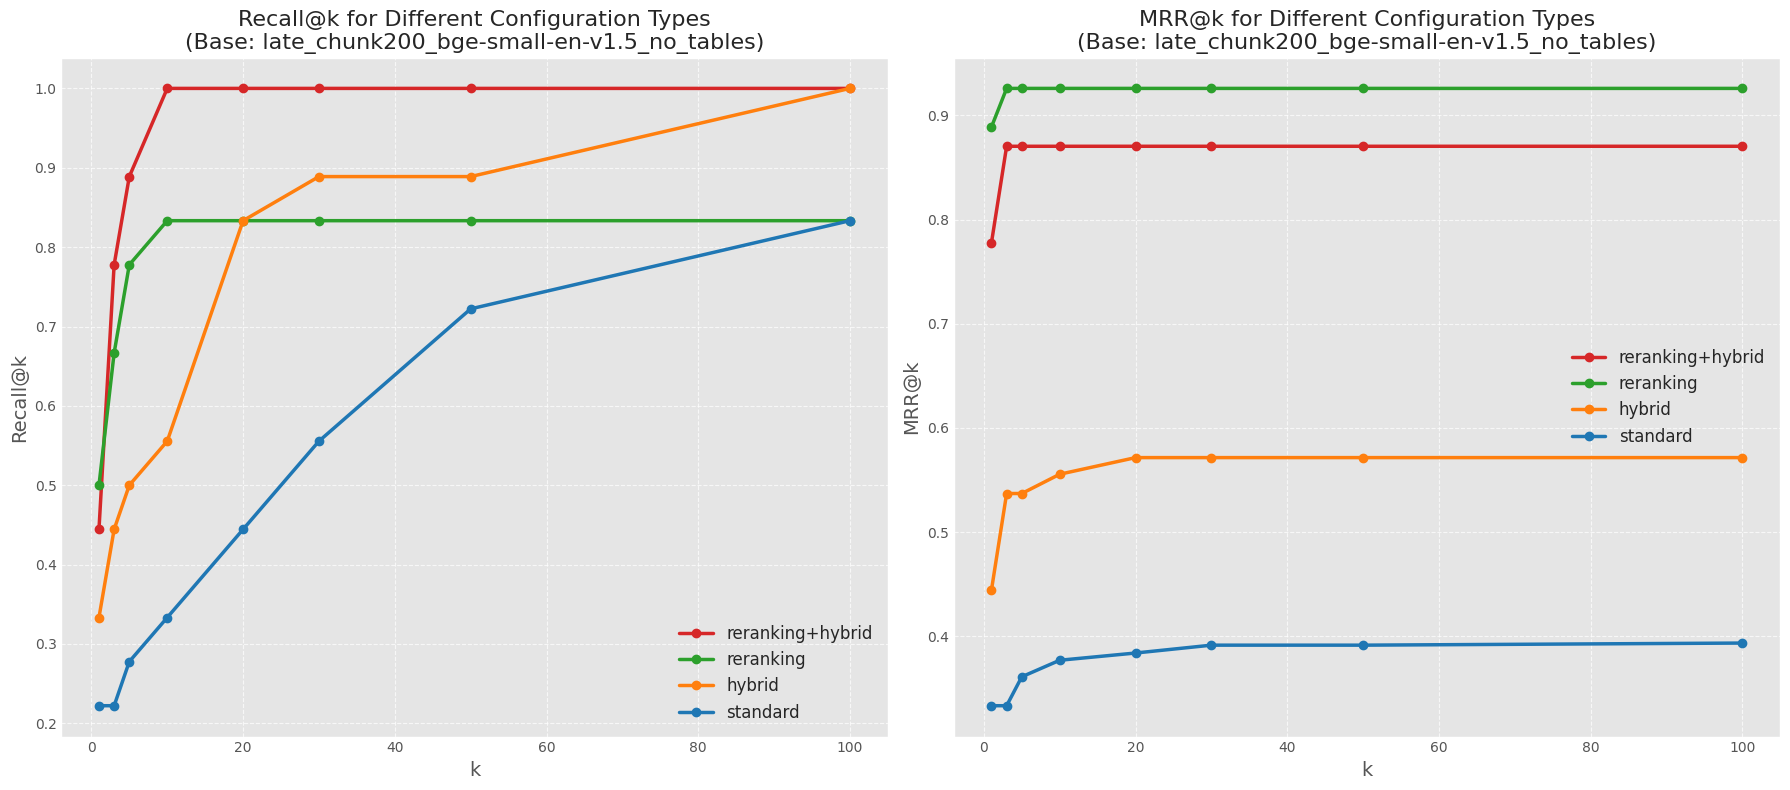

In [28]:
#| code-fold: true

# Create a column for the configuration type
df['config_type'] = 'standard'
df.loc[df['hybrid_search'] & ~df['reranking'], 'config_type'] = 'hybrid'
df.loc[~df['hybrid_search'] & df['reranking'], 'config_type'] = 'reranking'
df.loc[df['hybrid_search'] & df['reranking'], 'config_type'] = 'reranking+hybrid'

# Create embedding_size column - make sure this is properly created before using it
df['embedding_size'] = df['embedding_model'].apply(
    lambda x: 'small' if 'small' in str(x) else ('large' if 'large' in str(x) else 'base')
)

# Get all recall@k columns
recall_columns = [col for col in df.columns if col.startswith('recall@')]
k_values = sorted([int(col.split('@')[1]) for col in recall_columns])

# 1. First plot: Show one base configuration with the four options displaying recall vs k
# Find a base configuration that has all four variants
base_configs = []
for config in df['config_name'].str.rsplit('_', n=1).str[0].unique():
    variants = df[df['config_name'].str.startswith(config)]
    if len(variants['config_type'].unique()) >= 4:
        base_configs.append(config)

if base_configs:
    # Find the base configuration with the highest average recall across variants
    best_base = None
    best_avg_recall = 0
    
    for base in base_configs:
        variants = df[df['config_name'].str.startswith(base)]
        avg_recall = variants['avg_recall'].mean()
        if avg_recall > best_avg_recall:
            best_avg_recall = avg_recall
            best_base = base
    
    selected_base = best_base if best_base else base_configs[0]
    print(f"Selected best base configuration: {selected_base} (avg recall: {best_avg_recall:.4f})")
    
    # Get the variants for this base configuration
    variants_df = df[df['config_name'].str.startswith(selected_base)]
    
    # Create a figure with 2 subplots (Recall and MRR)
    plt.figure(figsize=(18, 8))
    
    # Subplot for Recall@k
    plt.subplot(1, 2, 1)
    
    # Define colors for the configuration types
    config_colors = {
        'standard': '#1f77b4',     # Blue
        'hybrid': '#ff7f0e',       # Orange
        'reranking': '#2ca02c',    # Green
        'reranking+hybrid': '#d62728'  # Red
    }
    
    # Plot each configuration type for Recall
    for config_type in variants_df['config_type'].unique():
        config_row = variants_df[variants_df['config_type'] == config_type].iloc[0]
        recalls = [config_row[f'recall@{k}'] for k in k_values]
        
        plt.plot(
            k_values, 
            recalls, 
            marker='o', 
            linewidth=2.5, 
            label=config_type,
            color=config_colors.get(config_type, '#7f7f7f')
        )
    
    plt.xlabel('k', fontsize=14)
    plt.ylabel('Recall@k', fontsize=14)
    plt.title(f'Recall@k for Different Configuration Types\n(Base: {selected_base})', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Subplot for MRR@k
    plt.subplot(1, 2, 2)
    
    # Plot each configuration type for MRR
    for config_type in variants_df['config_type'].unique():
        config_row = variants_df[variants_df['config_type'] == config_type].iloc[0]
        mrrs = [config_row[f'mrr@{k}'] for k in k_values]
        
        plt.plot(
            k_values, 
            mrrs, 
            marker='o', 
            linewidth=2.5, 
            label=config_type,
            color=config_colors.get(config_type, '#7f7f7f')
        )
    
    plt.xlabel('k', fontsize=14)
    plt.ylabel('MRR@k', fontsize=14)
    plt.title(f'MRR@k for Different Configuration Types\n(Base: {selected_base})', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    plt.tight_layout()

## Retrieval evaluation

The previous plot is fairly representative of the four retrieval options. This is illustrated below, where the statistics across all base configurations are represented as a box and whisker plot. Here we draw the same conclusion, that standard retrieval performs poorly while the best results use a combination of reranking and hybrid search.

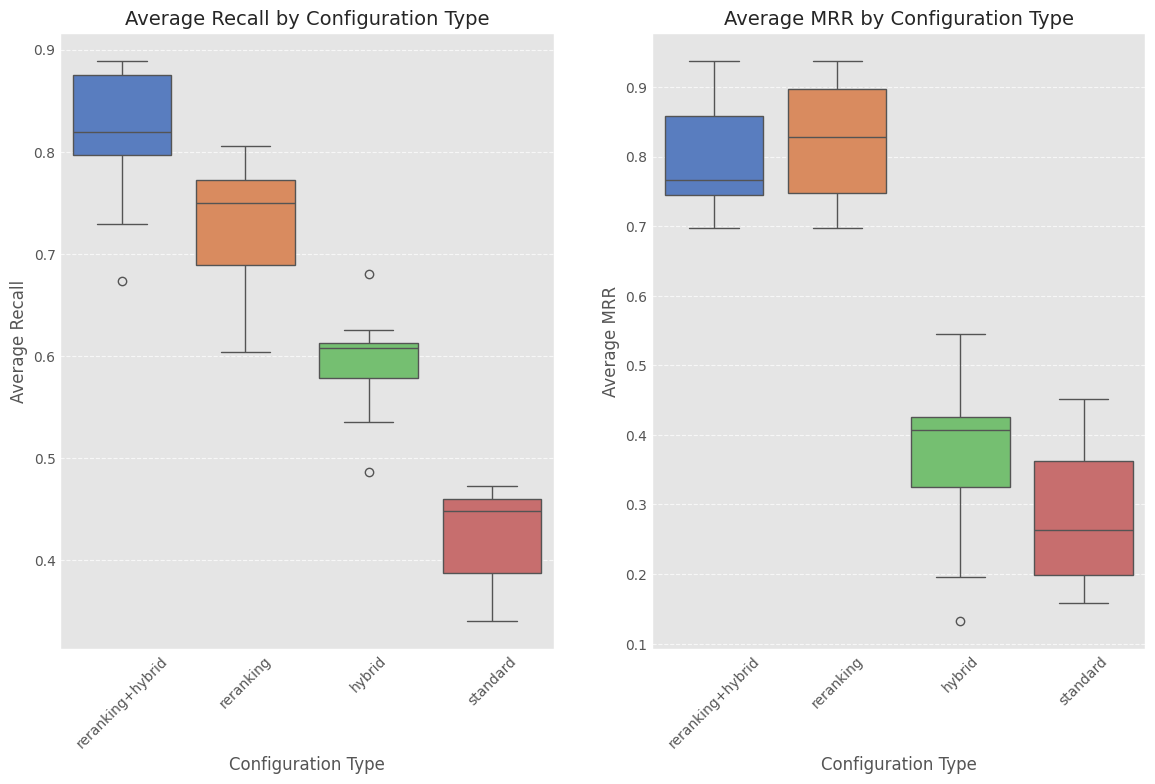

In [30]:
#| code-fold: true

# 2. Box and whisker plot showing performance of the four options (fixing the warning)
plt.figure(figsize=(14, 8))

# Subplot for average recall by configuration type
plt.subplot(1, 2, 1)
# Fix: Use hue parameter instead of palette directly
sns.boxplot(x='config_type', y='avg_recall', hue='config_type', data=df, palette='muted', legend=False)
plt.title('Average Recall by Configuration Type', fontsize=14)
plt.xlabel('Configuration Type', fontsize=12)
plt.ylabel('Average Recall', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot for average MRR by configuration type
plt.subplot(1, 2, 2)
# Fix: Use hue parameter instead of palette directly
sns.boxplot(x='config_type', y='avg_mrr', hue='config_type', data=df, palette='muted', legend=False)
plt.title('Average MRR by Configuration Type', fontsize=14)
plt.xlabel('Configuration Type', fontsize=12)
plt.ylabel('Average MRR', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

## Chunking strategy

Now let's consider the best chunking strategy (token, semantic or late). The plot below again shows the statistics across all relevant base configurations for these three strategies. Although there is significant variation, we can see that the late chunking approach has the best overall recall and the highest median recall. Perhaps surprisingly, the semantic approach performs worse than the naive token chunking method. 

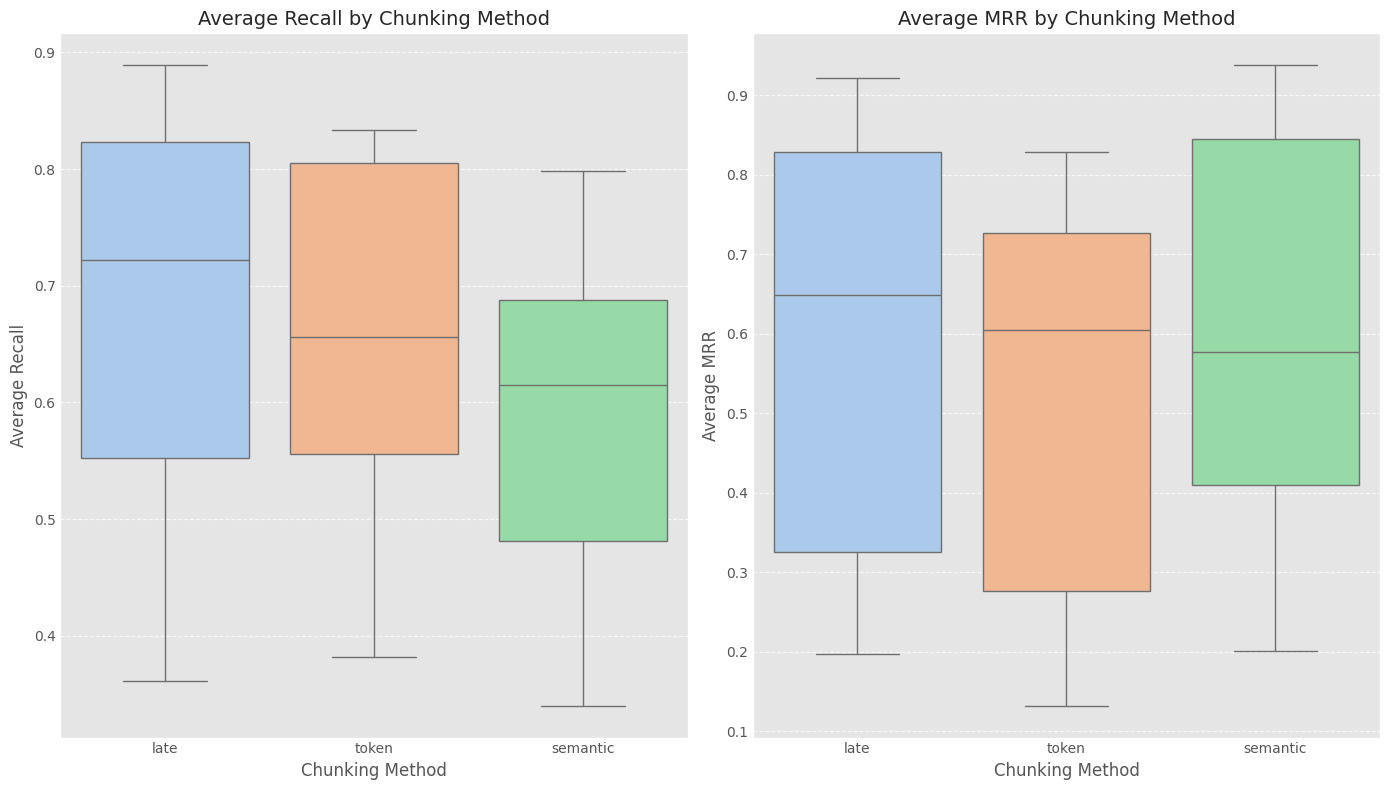

In [31]:
#| code-fold: true

# 3. Comparison of chunking strategies (token, semantic, late)
plt.figure(figsize=(14, 8))

# Subplot for average recall by chunking method
plt.subplot(1, 2, 1)
# Fix: Use hue parameter instead of palette directly
sns.boxplot(x='chunking_method', y='avg_recall', hue='chunking_method', data=df, palette='pastel', legend=False)
plt.title('Average Recall by Chunking Method', fontsize=14)
plt.xlabel('Chunking Method', fontsize=12)
plt.ylabel('Average Recall', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Subplot for average MRR by chunking method
plt.subplot(1, 2, 2)
# Fix: Use hue parameter instead of palette directly
sns.boxplot(x='chunking_method', y='avg_mrr', hue='chunking_method', data=df, palette='pastel', legend=False)
plt.title('Average MRR by Chunking Method', fontsize=14)
plt.xlabel('Chunking Method', fontsize=12)
plt.ylabel('Average MRR', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

## Embedding model

Now let's examine the effect of the embedding model size for the results in the late chunking strategy. Surprisingly, the plot below indicates that there is little improvement when using the large embedding model. In fact, the median for both metrics is better using the small embedding model.

2025-03-15 11:25:39,117 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-15 11:25:39,123 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Columns in late_df: ['config_name', 'chunking_method', 'chunk_size', 'embedding_model', 'with_tables', 'reranking', 'hybrid_search', 'recall@1', 'mrr@1', 'recall@3', 'mrr@3', 'recall@5', 'mrr@5', 'recall@10', 'mrr@10', 'recall@20', 'mrr@20', 'recall@30', 'mrr@30', 'recall@50', 'mrr@50', 'recall@100', 'mrr@100', 'avg_recall', 'avg_mrr', 'config_type', 'embedding_size']
Number of late chunking configurations: 16


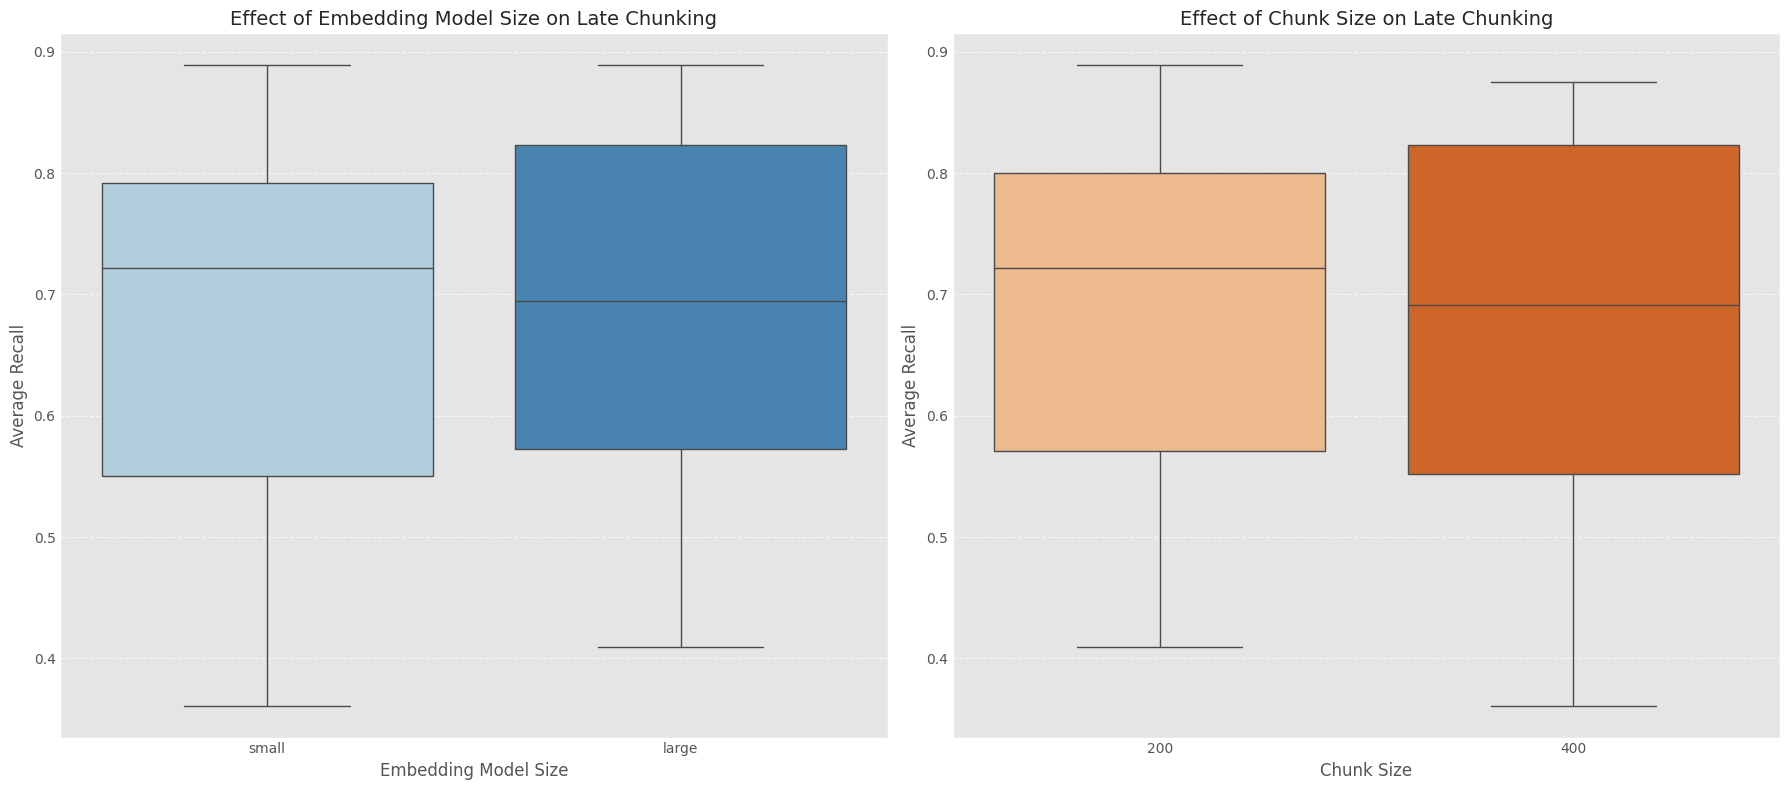

In [35]:
#| code-fold: true

# 4. Take only the results for the late configurations and demonstrate the effect of embedding model size and chunk size
late_df = df[df['chunking_method'] == 'late'].copy()

# Check if we have the required columns
print("Columns in late_df:", late_df.columns.tolist())
print("Number of late chunking configurations:", len(late_df))

# Create a figure with 2 subplots
plt.figure(figsize=(18, 8))

# Subplot for embedding model size effect on late chunking
plt.subplot(1, 2, 1)
# Make sure embedding_size column exists and has values
if 'embedding_size' in late_df.columns and not late_df['embedding_size'].isna().all():
    sns.boxplot(x='embedding_size', y='avg_recall', hue='embedding_size', data=late_df, palette='Blues', legend=False)
    plt.title('Effect of Embedding Model Size on Late Chunking', fontsize=14)
    plt.xlabel('Embedding Model Size', fontsize=12)
    plt.ylabel('Average Recall', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
else:
    plt.text(0.5, 0.5, 'No embedding_size data available', 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=14)
    plt.axis('off')

# Subplot for chunk size effect on late chunking
plt.subplot(1, 2, 2)
if 'chunk_size' in late_df.columns and not late_df['chunk_size'].isna().all():
    # Convert chunk_size to string for categorical plotting
    late_df['chunk_size_str'] = late_df['chunk_size'].astype(str)
    sns.boxplot(x='chunk_size_str', y='avg_recall', hue='chunk_size_str', data=late_df, palette='Oranges', legend=False)
    plt.title('Effect of Chunk Size on Late Chunking', fontsize=14)
    plt.xlabel('Chunk Size', fontsize=12)
    plt.ylabel('Average Recall', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
else:
    plt.text(0.5, 0.5, 'No chunk_size data available', 
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes, fontsize=14)
    plt.axis('off')

plt.tight_layout()

## Best configuration

Finally, the best configuration for each chunking strategy is shown in the plot below. In each case the best result corresponds with a retrieval strategy utilizing hybrid search plus reranking. This shows that the best overall results (in terms of recall) are obtained by the late chunking approach using the small embedding model and maximum chunk size of 200 tokens. The best semantic chunking results perform best at small values of k (reflected by the MRR results), but is quickly surpassed by both the token and late chunking methods. Ultimately, the semantic chunking method was unable to retrieve all related references (recall less than 1.0), even when the number of chunks included was increased to 100.

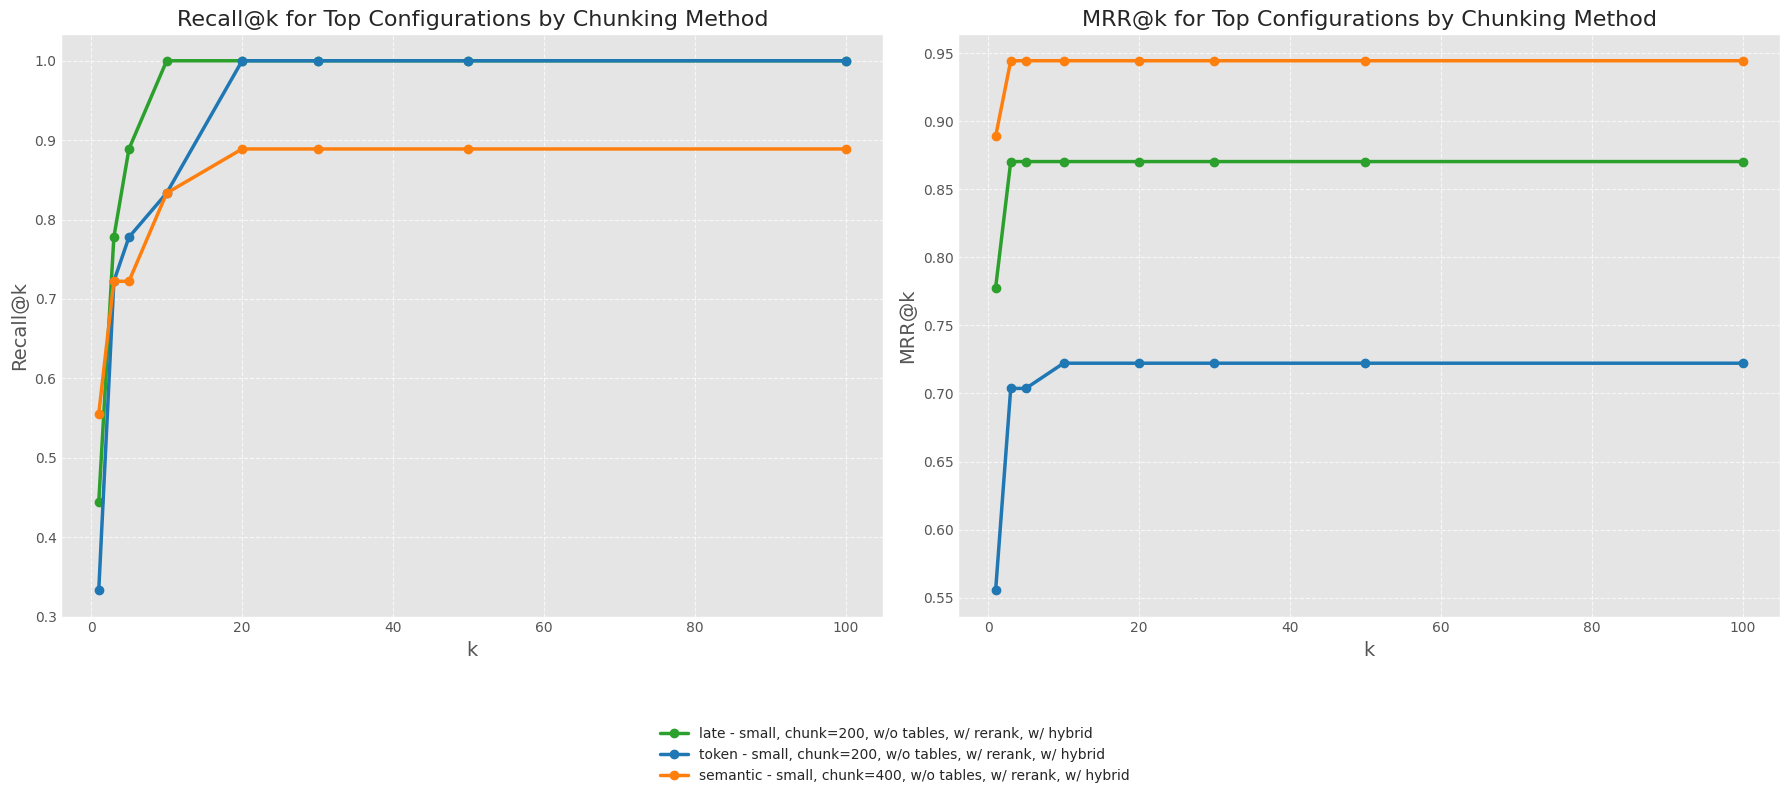

In [34]:
#| code-fold: true

# 5. Recall vs k and MRR vs k for top configurations of each chunking method with better legend placement
# Find the top configuration for each chunking method
top_configs = []
for chunking in df['chunking_method'].unique():
    chunking_df = df[df['chunking_method'] == chunking]
    if not chunking_df.empty:
        top_config = chunking_df.loc[chunking_df['avg_recall'].idxmax()]
        top_configs.append(top_config)

# Create a DataFrame with the top configurations
top_configs_df = pd.DataFrame(top_configs)

# Create a figure with 2 subplots (Recall and MRR)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Define colors for the chunking methods
chunking_colors = {
    'token': '#1f77b4',    # Blue
    'semantic': '#ff7f0e', # Orange
    'late': '#2ca02c'      # Green
}

# Create line objects and labels for the legend
lines = []
labels = []

# Subplot for Recall@k
for _, row in top_configs_df.iterrows():
    chunking = row['chunking_method']
    config_name = row['config_name']
    recalls = [row[f'recall@{k}'] for k in k_values]
    
    # Create a descriptive label that includes key configuration details
    label = (f"{chunking} - {row['embedding_size']}, chunk={row['chunk_size']}, "
             f"{'w/' if row['with_tables'] else 'w/o'} tables, "
             f"{'w/' if row['reranking'] else 'w/o'} rerank, "
             f"{'w/' if row['hybrid_search'] else 'w/o'} hybrid")
    
    line, = ax1.plot(
        k_values, 
        recalls, 
        marker='o', 
        linewidth=2.5, 
        label=label,
        color=chunking_colors.get(chunking, '#7f7f7f')
    )
    
    # Store line and label for the legend
    lines.append(line)
    labels.append(label)

ax1.set_xlabel('k', fontsize=14)
ax1.set_ylabel('Recall@k', fontsize=14)
ax1.set_title('Recall@k for Top Configurations by Chunking Method', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.7)

# Subplot for MRR@k
for _, row in top_configs_df.iterrows():
    chunking = row['chunking_method']
    config_name = row['config_name']
    mrrs = [row[f'mrr@{k}'] for k in k_values]
    
    ax2.plot(
        k_values, 
        mrrs, 
        marker='o', 
        linewidth=2.5, 
        color=chunking_colors.get(chunking, '#7f7f7f')
    )

ax2.set_xlabel('k', fontsize=14)
ax2.set_ylabel('MRR@k', fontsize=14)
ax2.set_title('MRR@k for Top Configurations by Chunking Method', fontsize=16)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add a single legend at the bottom of the figure
fig.legend(lines, labels, loc='lower center', ncol=1, fontsize=10, bbox_to_anchor=(0.5, 0))

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0.15, 1, 1])  # Leave space at the bottom for the legend


Note here that using basic token chunking is very competitive to the late-binding approach when hybrid search and reranking are included. In the case of the benchmarking dataset, the first ten chunks are required for each question to ensure full reference retrieval in the case of late-binding chunking. For token-based chunking, we have to include the first 20 reranked chunks to achieve a recall of 1. The chunks are quite small, so we could easily pass more than 20 chunks to the LLM, so which approach is more appropriate would need to take into account the LLM being used, the additional computational overhead for late-binding chunking etc...

# Discussion

Our evaluation of different retrieval approaches for financial document RAG systems reveals several key insights:

## Standard Retrieval Limitations

Standard retrieval consistently underperforms across all metrics. This is primarily because financial documents contain similar information patterns (e.g., "Revenue for year X was $Y") without explicitly referencing the company name in each section. When documents are chunked and embedded, this critical global context (company identity and reporting period) is lost, resulting in poor retrieval performance.

## Hybrid Search and Reranking Synergy

The combination of hybrid search (metadata filtering) and reranking produces the best overall results. Metadata filtering effectively reintroduces the global context (company name and year) that was lost during chunking, while reranking further refines the relevance of retrieved chunks. This combined approach addresses the fundamental context loss issue in financial document retrieval.

## Chunking Strategy Considerations

Late-binding chunking, which attempts to preserve global context in embeddings, performed best among chunking strategies. However, its advantage over basic token chunking diminishes significantly when metadata filtering and reranking are applied. We'd have to weigh the additional computational cost against the small performance gains when selecting a chunking strategy.

## Semantic Chunking Ineffectiveness

Contrary to expectations, semantic chunking did not improve retrieval performance. This is because the most critical context elements in financial documents (company name and reporting period) are not effectively preserved through semantic boundaries alone. The global context problem requires more direct intervention (which are addressed better by metadata filtering and late-binding chunking).

## Future Optimization Opportunities

An untested approach worth exploring is explicitly prepending key contextual information (company name, year, section) to each chunk before embedding. This would encode the critical global context directly into the vector representation, potentially improving retrieval without requiring separate metadata filtering.

## Performance and Cost Tradeoffs

While reranking significantly improves retrieval quality, it introduces additional computational overhead. With reranking, more chunks must be retrieved initially to ensure relevant information is captured. System designers must balance retrieval quality against latency and cost constraints when determining optimal reranking parameters.


## Further improvements
There are many improvements and alternatives that could be tested, but here we list a few ideas:

* Currently a rule-based approach is used to extract metadata for hybrid search. This will not work well in the case of spelling mistakes and can also result in incorrect filtering (e.g. if we include Google in the request, the current approach includes GE in the company metadata filtering). Better alternatives may be to use Named Entity Recognition (NER) or LLM for metadata extraction.
* Tabular data is omitted from the embedding process in the current workflow. To include the table data we need to add an extra step, where we send the table (and surrounding context) to an LLM to describe what it contains. We would use the description to generate the embedding, which should help it align better with user queries.
* The use of an embedding model fine-tuned on fininacial data may be beneficial.


# RAG Pipeline Evaluation Summary
Based on our analysis of various RAG pipelines, several key patterns in retrieval performance were identified:

* **Standard Retrieval Limitations**: Standard retrieval consistently performs the worst across all metrics. Without the benefits of metadata filtering or reranking, this basic approach struggles to effectively identify and prioritize relevant content.
* **Enhanced Retrieval Approaches**: Results are significantly improved by the addition of either metadata filtering (hybrid search) or reranking. Hybrid search ensures comprehensive retrieval of relevant chunks (by adding document level (i.e. company) level context to the information), while reranking optimizes the ordering of these chunks to prioritize the most relevant content. The best overall results are achieved by combining hybrid search with reranking. 
* **Late-binding chunking**: Showed the best overall performance for the chunking strategy by maintaining awareness of the entire document's context in each chunk. This approach significantly reduces the "tunnel vision" problem where traditional chunks lack awareness of information outside their boundaries. However, the basic token strategy wasn't far behind once we include reranking and metadata filtering.

Th
